In [1]:
from database.strategy import Strategy
from database.sec import SEC
from database.market import Market
from transformer.date_transformer import DateTransformer
from transformer.column_transformer import ColumnTransformer
from transformer.model_transformer import ModelTransformer
from transformer.product_transformer import ProductTransformer
from transformer.predictor_transformer import PredictorTransformer
from preprocessor.model_preprocessor import ModelPreprocessor
from preprocessor.predictor_preprocessor import PredictorPreprocessor
from modeler.modeler import Modeler as sp
from utils.date_utils import DateUtils
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
from tqdm import tqdm
import math
import numpy as np

In [2]:
## Loading Constants
start = "2008-01-01"
end = datetime(2021,1,1).strftime("%Y-%m-%d")
# Loading Databases
strat_db = Strategy("unity")
market = Market()
sec = SEC("sec")
market.connect()
tickers = market.retrieve_data("sp500").sort_values("Symbol")
market.close()
quarterly_range = range(1,5)
yearly_range = range(2018,2021)
model_range = range(len(tickers["Symbol"]))

In [40]:
market.connect()
quarterly_classification_data = market.retrieve_data("dataset_pdr_quarter_classification")
quarterly_regression_data = market.retrieve_data("dataset_pdr_quarter_regression")
accurate = market.retrieve_data("accurate")
relevant_tickers = list(accurate["ticker"])
relevant_tickers.extend(["date","year","quarter"])
market.close()
for col in quarterly_regression_data.columns:
    if -99999 == quarterly_regression_data[col].min() or col not in relevant_tickers:
        quarterly_regression_data.drop(col,axis=1,inplace=True)
for col in quarterly_classification_data.columns:
    if -99999 == quarterly_classification_data[col].min() or col not in relevant_tickers:
        quarterly_classification_data.drop(col,axis=1,inplace=True)

In [41]:
sims = []
sec.connect()
strat_db.connect()
market.connect()
### switch to all tickers
fundamentals = []
for ticker in tqdm(list(accurate["ticker"])):
    try:
        cik = int(tickers[tickers["Symbol"]==ticker]["CIK"].item())
        filing = sec.retrieve_filing_data(cik)
        funds = filing.copy()
        ## date transformations and gap management
        funds["filed"] = [datetime.strptime(str(x),"%Y%m%d").replace(tzinfo=timezone.utc) if "-" not in str(x) else \
                            datetime.strptime(str(x).split(" ")[0],"%Y-%m-%d").replace(tzinfo=timezone.utc) for x in funds["filed"]]
        funds["quarter"] = [x.quarter for x in funds["filed"]]
        funds["year"] = [x.year for x in funds["filed"]]
        funds.drop(["_id","adsh","cik","filed"],axis=1,inplace=True)
        ## merge
        price = quarterly_regression_data[["year","quarter",ticker]].copy()
        ticker_data = funds.merge(price,on=["year","quarter"])
        ticker_data.rename(columns={ticker:"adjclose"},inplace=True)
        ticker_data["ticker"] = ticker
        ticker_data = ticker_data.groupby(["year","ticker"]).mean().reset_index()
        ticker_data["adjclose"] = ticker_data["adjclose"].pct_change().shift(-1)
        ticker_data["Liabilities"] = ticker_data["LiabilitiesAndStockholdersEquity"] - ticker_data["StockholdersEquity"]
        for col in ["Assets","Liabilities","StockholdersEquity"]:
            ticker_data[col] = ticker_data[col].pct_change()
        fundamentals.append(ticker_data)
    except Exception as e:
        print(str(e))
sec.close()
market.close()
strat_db.close()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 17.10it/s]

'StockholdersEquity'


In [35]:
f = pd.concat(fundamentals)
stuff = f[["year","quarter","Assets","Liabilities","StockholdersEquity","ticker","adjclose"]].dropna()

In [36]:
f[["Assets","Liabilities","ticker"]]

,Assets,Liabilities,ticker
0,NaN,NaN,BRK-B
1,0.128584,0.120165,BRK-B
2,0.086917,0.034036,BRK-B
3,0.087635,0.080481,BRK-B
4,0.090084,0.048247,BRK-B
...,...,...,...
6,0.674384,0.563634,LKQ
7,0.564867,0.677055,LKQ
8,0.451558,0.640193,LKQ
9,0.350713,0.519749,LKQ


In [31]:
train = stuff.iloc[:int(f.index.size*0.7)]
test = stuff.iloc[int(f.index.size*0.7):]
regression_results = sp.regression({"X":train[["Assets","Liabilities","StockholdersEquity"]],"y":train["adjclose"]},tf=False,deep=False,ranked=False)

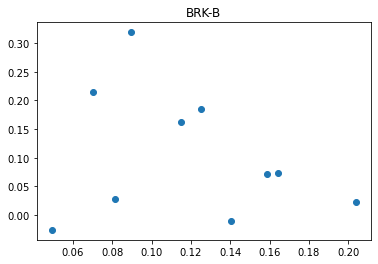

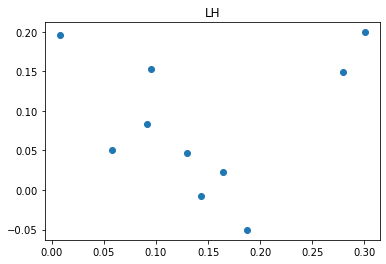

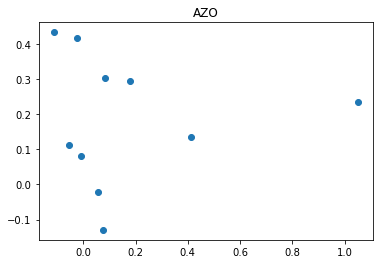

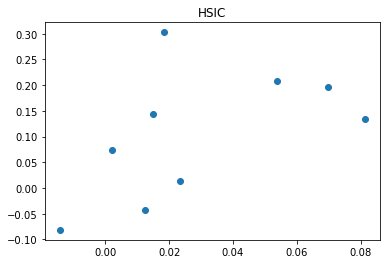

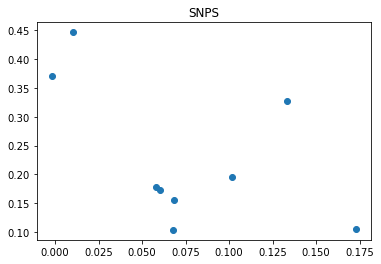

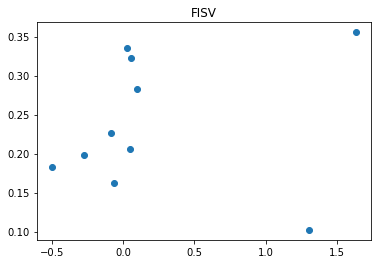

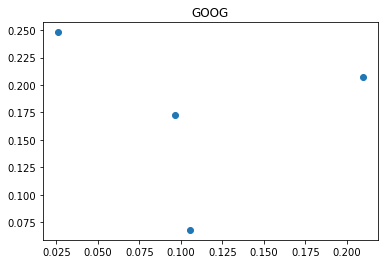

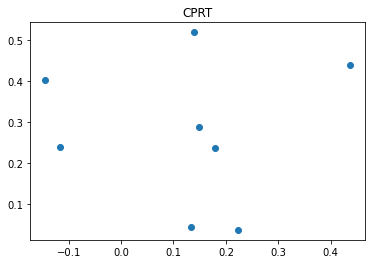

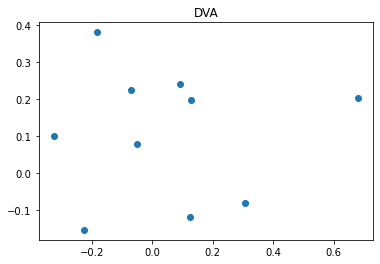

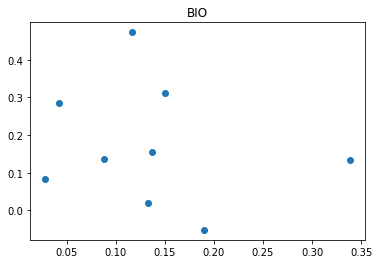

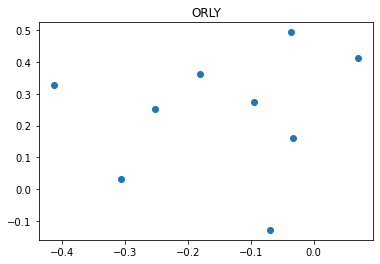

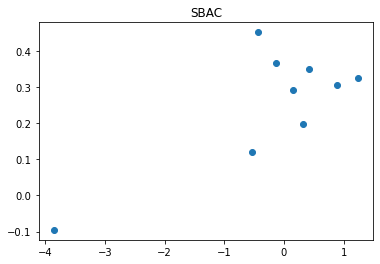

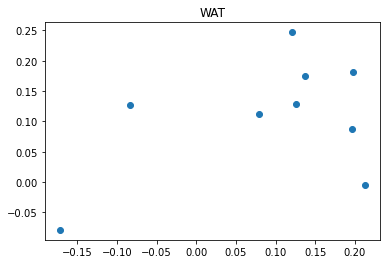

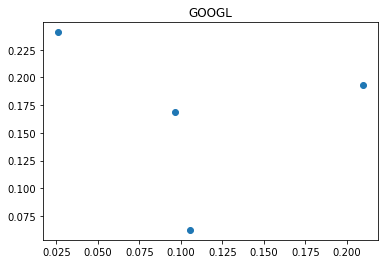

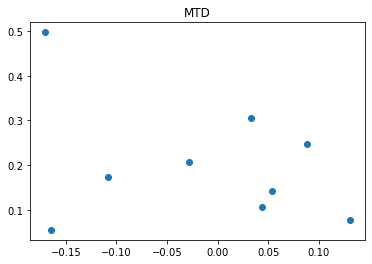

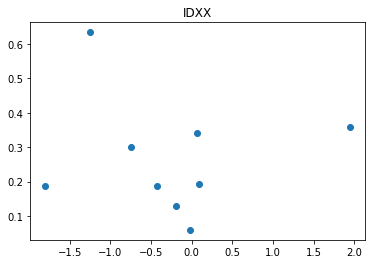

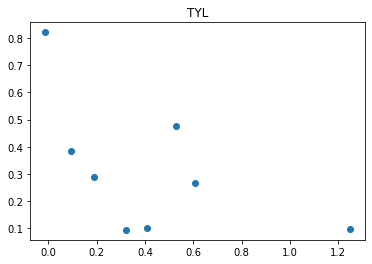

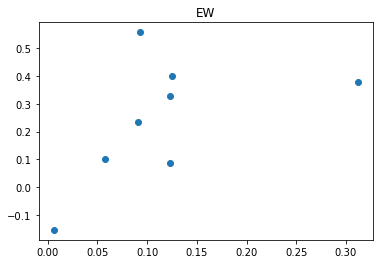

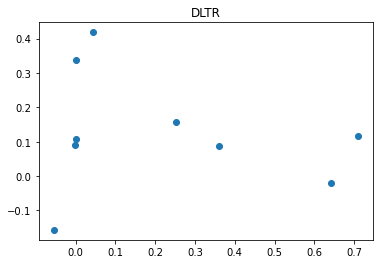

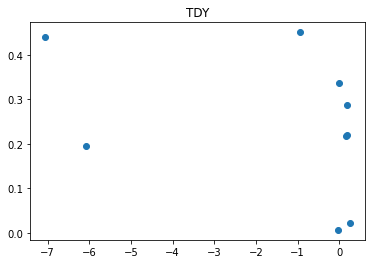

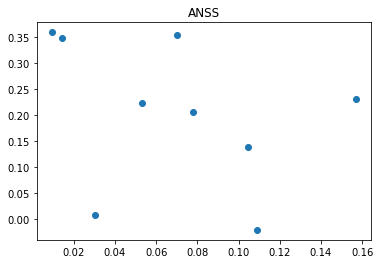

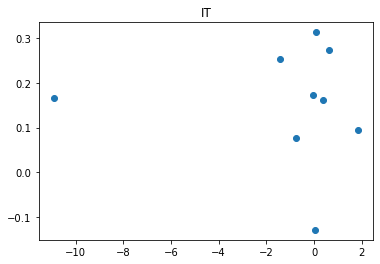

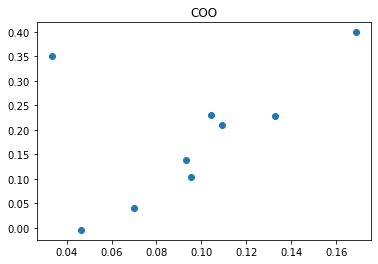

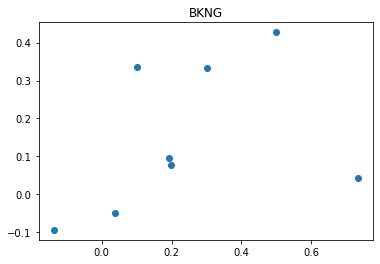

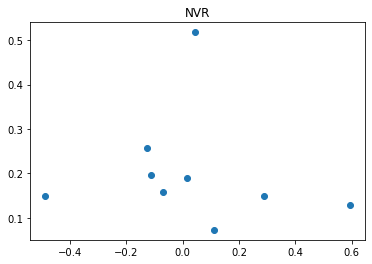

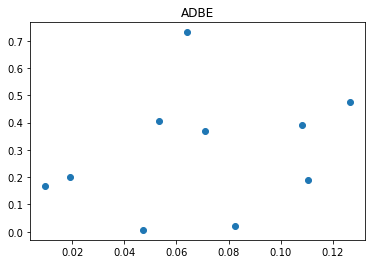

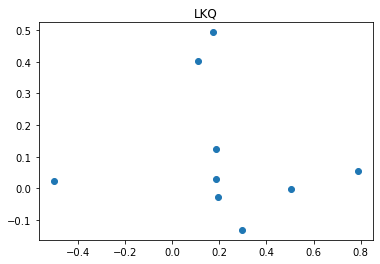

In [37]:
for ticker in f.ticker.unique():
    relevant = f[(f["StockholdersEquity"] <= 10) & (f["ticker"]==ticker)]
    plt.scatter(relevant["StockholdersEquity"],relevant["adjclose"])
    plt.title(ticker)
    plt.show()

In [39]:
f[["Assets","Liabilities","StockholdersEquity","adjclose"]].corr()

,Assets,Liabilities,StockholdersEquity,adjclose
Assets,1.000000,0.773348,0.172908,-0.044644
Liabilities,0.773348,1.000000,0.126290,-0.027785
StockholdersEquity,0.172908,0.126290,1.000000,-0.029258
adjclose,-0.044644,-0.027785,-0.029258,1.000000
